In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Libraries

##  Remove warnings

In [2]:
import warnings
warnings.filterwarnings( 'ignore' )

## Import libraries

In [3]:
# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Basic libraries
#
import time
import random
import pandas    as pd
import numpy     as np
from   tqdm      import tqdm


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Visualization library
#
import matplotlib.pyplot   as plt 


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Sklearn library
#
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
#
# Torch libraries
#
import torch
import torch.nn                     as nn
import torch.nn.functional          as F
from   torch.utils.data             import DataLoader
from   torch.utils.data             import Dataset


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
#
# User libraries
#
from utils.PerformanceMetrics import RegressionEvaluation
from utils.EarlyStopping      import *
from utils.LRScheduler        import *



from models.DeepTIMe    import *
from models.TimeFeature import *

# Parameters

In [4]:
import random
import os
# Set seed
#
seed = 1999
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

## CUDA

In [5]:
# device = torch.device( 'cpu' )
try:
    torch.cuda.init()

    if (torch.cuda.is_available() == True):
        print('[INFO] CUDA is available')

        device = torch.device( 'cuda:0' )
        print('[INFO] Device name: %s' % torch.cuda.get_device_name(0))

    else:
        print('[INFO] CUDA is not available')
        device = torch.device( 'cpu' )
except:
    print('[INFO] CUDA is not available')
    device = torch.device( 'cpu' )

[INFO] CUDA is available
[INFO] Device name: Quadro GV100


## Neural networks parameters

In [6]:
class Parameters():
    def __init__(self):
        self.description = 'DeepTIMe: Deep Time-Index Meta-Learning for Non-Stationary Time-Series Forecasting'
    
        # =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
        # Neural network model parameters
        #
        # Input sequence length - look-back
        self.Lag             = 3 * 24
        # Prediction sequence length
        self.Horizon         = 24
        
        # Training parameters
        #
        # Number of epochs
        self.epochs          = 1000
        # Batch size
        self.batch_size      = 512
        # Number of workers in DataLoader
        self.num_workers     = 0
        # Define verbose
        self.verbose         = True
        # Learning rate
        self.learning_rate   = 0.01
        # weight_decay
        self.weight_decay    = 0.00001
        # Trained model path
        self.model_path      = 'checkpoints/DeepTIMe.pth'
        # Layer size (neurons)
        self.layer_size      = 32
        # Number of INR layers
        self.inr_layers      = 1
        # Number of Fourier feats
        self.n_fourier_feats = 512
        # Clip gradient
        self.clip_grads      = True
        # Norm for clip gradient                
        self.clip_grads_norm = 0.5

                    
        # Data handling
        #
        # Filename
        self.filename              = './data/Electricity_data_mean_resampling.csv'
        # Target series name 
        self.targetSeries          = 'W_elect'
        # Data Log-transformation
        self.Transformation        = True
        # Scaling {'Standard', 'MinMax', 'Robust'}
        self.Scaling               = 'Standard'
        # Smoothing
        self.Smoothing             = False
        #
        self.window_len  = 4        # [2, 10]
        self.window_type = 'bartlett' # ['ones', 'hanning', 'hamming', 'bartlett', 'blackman']


args = Parameters()

In [7]:
# class Parameters():
#     def __init__(self):
#         self.description = 'DeepTIMe: Deep Time-Index Meta-Learning for Non-Stationary Time-Series Forecasting'
    
#         # =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
#         # Neural network model parameters
#         #
#         # Input sequence length - look-back
#         self.Lag             = 3 * 24
#         # Prediction sequence length
#         self.Horizon         = 24
        
#         # Training parameters
#         #
#         # Number of epochs
#         self.epochs          = 1000
#         # Batch size
#         self.batch_size      = 512
#         # Number of workers in DataLoader
#         self.num_workers     = 0
#         # Define verbose
#         self.verbose         = True
#         # Learning rate
#         self.learning_rate   = 0.01
#         # weight_decay
#         self.weight_decay    = 0.00001
#         # Trained model path
#         self.model_path      = 'checkpoints/DeepTIMe.pth'
#         # Layer size (neurons)
#         self.layer_size      = 32
#         # Number of INR layers
#         self.inr_layers      = 1
#         # Number of Fourier feats
#         self.n_fourier_feats = 512
#         # Clip gradient
#         self.clip_grads      = True
#         # Norm for clip gradient                
#         self.clip_grads_norm = 0.2 

                    
#         # Data handling
#         #
#         # Filename
#         self.filename              = './data/Electricity_data_mean_resampling.csv'
#         # Target series name 
#         self.targetSeries          = 'W_elect'
#         # Data Log-transformation
#         self.Transformation        = True
#         # Scaling {'Standard', 'MinMax', 'Robust'}
#         self.Scaling               = 'Standard'
#         # Smoothing
#         self.Smoothing             = False
#         #
#         self.window_len  = 4        # [2, 10]
#         self.window_type = 'bartlett' # ['ones', 'hanning', 'hamming', 'bartlett', 'blackman']


# args = Parameters()

# Data handling

## Import data


In [8]:
# Start timer
#
start = time.time()

# Load data
#
df = pd.read_csv( args.filename )

print('[INFO] Data imported')
print('[INFO] Time: %.2f seconds' % (time.time() - start))

df.head( 3 )

[INFO] Data imported
[INFO] Time: 0.02 seconds


,Date,W_elect
0,2018-03-05 12:00:00,5.819950
1,2018-03-05 13:00:00,5.819950
2,2018-03-05 14:00:00,6.337738


## Preprocess data

### Set index

In [9]:
# Convert Date to 'datetime64'
#
df['Date'] = df['Date'].astype('datetime64')

# Set index
#
df.set_index('Date', inplace=True)


# Keep only selected time-series
#
df = pd.DataFrame( df[ [ args.targetSeries ] ] )


df.head( 3 )

,W_elect
Date,
2018-03-05 12:00:00,5.819950
2018-03-05 13:00:00,5.819950
2018-03-05 14:00:00,6.337738


### Split Training/Testing

In [10]:
df_train = df[ df.index <  '2022-01-01 12:00:00' ]
df_test  = df[ df.index >= '2022-01-01 12:00:00' ]

In [11]:
# df = df[df.index >= '2018-03-06 00:00:00']

# df_train = df[ df.index <  '2022-01-01 00:00:00' ]
# df_test  = df[ df.index >= '2022-01-01 00:00:00' ]

### Visualization

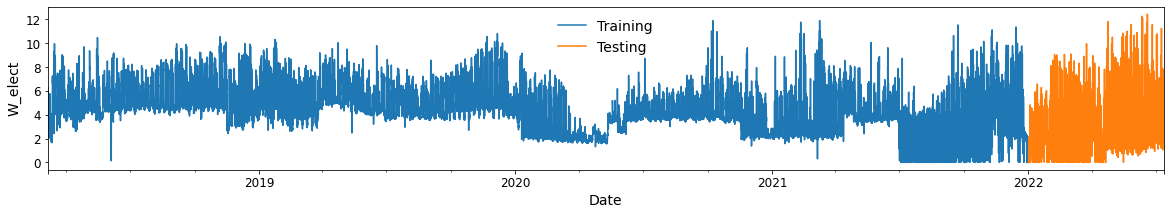

In [12]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(20, 3) )

df_train[ args.targetSeries ].plot(ax=ax, color='tab:blue' )
df_test[ args.targetSeries ].plot(ax=ax,  color='tab:orange')

plt.legend(['Training', 'Testing'], frameon = False, fontsize = 14)
plt.ylabel(args.targetSeries, size = 14)
plt.xlabel('Date', size = 14);
plt.xticks(size = 12);
plt.yticks(size = 12);

## Preprocessing

### Data Transformation

In [13]:
if (args.Transformation == True):
    
    print('[INFO] Data transformation applied')
    
    VALUE = np.ceil( max(abs( -df.min().min() ), 1.0) )
    
    df_train = np.log( df_train + VALUE)
    df_test  = np.log( df_test  + VALUE)
    
else:
    print('[INFO] No data transformation applied.')  

[INFO] Data transformation applied


### Scaling

In [14]:
if (args.Scaling == 'MinMax'):
    print('[INFO] Scaling: MinMax')
    
    for feature in df.columns:
        if (feature ==  args.targetSeries ): continue
        print('Feature: ', feature)        
        # Set scaler
        #
        scaler = MinMaxScaler()
        
        df_train[feature] = scaler.fit_transform( df_train[ feature ].to_numpy().reshape(-1,1) )
        df_test[feature]  = scaler.transform( df_test[ feature ].to_numpy().reshape(-1,1) )

        
    # Scaling of Target Series
    #
    scaler = MinMaxScaler()
    df_train[ args.targetSeries ] = scaler.fit_transform( df_train[  args.targetSeries  ].to_numpy().reshape(-1,1) )
    df_test[ args.targetSeries ]  = scaler.transform( df_test[  args.targetSeries  ].to_numpy().reshape(-1,1) )
            
elif (args.Scaling == 'Robust'):
    print('[INFO] Scaling: Robust')
    
    for feature in df.columns:
        if (feature ==  args.targetSeries ): continue
        print('Feature: ', feature)        
        # Set scaler
        #
        scaler = RobustScaler()
        
        df_train[feature] = scaler.fit_transform( df_train[ feature ].to_numpy().reshape(-1,1) )
        df_test[feature]  = scaler.transform( df_test[ feature ].to_numpy().reshape(-1,1) )

        
    # Scaling of Target Series
    #
    scaler = RobustScaler()
    df_train[ args.targetSeries ] = scaler.fit_transform( df_train[  args.targetSeries  ].to_numpy().reshape(-1,1) )
    df_test[ args.targetSeries ]  = scaler.transform( df_test[  args.targetSeries  ].to_numpy().reshape(-1,1) )
        
elif (args.Scaling == 'Standard'):
    print('[INFO] Scaling: Standard')

    for feature in df.columns:
        if (feature ==  args.targetSeries ): continue
        print('Feature: ', feature)
        # Set scaler
        #
        scaler = StandardScaler()
        
        df_train[feature] = scaler.fit_transform( df_train[ feature ].to_numpy().reshape(-1,1) )
        df_test[feature]  = scaler.transform( df_test[ feature ].to_numpy().reshape(-1,1) )

        
    # Scaling of Target Series
    #
    scaler = StandardScaler()

    df_train[ args.targetSeries ] = scaler.fit_transform( df_train[  args.targetSeries  ].to_numpy().reshape(-1,1) )
    df_test[ args.targetSeries ]  = scaler.transform( df_test[  args.targetSeries  ].to_numpy().reshape(-1,1) )             
else:
    print('[WARNING] Unknown data scaling. Standar scaling was selected')   
    
    for feature in df.columns:
        if (feature ==  args.targetSeries ): continue
        print('Feature: ', feature)
        # Set scaler
        #
        scaler = StandardScaler()
        
        df_train[feature] = scaler.fit_transform( df_train[ feature ].to_numpy().reshape(-1,1) )
        df_test[feature]  = scaler.transform( df_test[ feature ].to_numpy().reshape(-1,1) )

        
    # Scaling of Target Series
    #
    scaler = StandardScaler()

    df_train[ args.targetSeries ] = scaler.fit_transform( df_train[  args.targetSeries  ].to_numpy().reshape(-1,1) )
    df_test[ args.targetSeries ]  = scaler.transform( df_test[  args.targetSeries  ].to_numpy().reshape(-1,1) )  

[INFO] Scaling: Standard


### Smoothing

In [15]:
# %%time

# from tsmoothie.smoother import *

# if (args.Smoothing == True):
#     print('[INFO] Smoother: Convolution Smoother')

#     smoother = ConvolutionSmoother(window_len  = args.window_len,
#                                    window_type = args.window_type)
    
    
#     # Apply smoother
#     #
#     smoother.smooth( df_train[ args.targetSeries ] )
#     print('[INFO] Smoothing applied')
    
#     df_train[ args.targetSeries ] = smoother.smooth_data.T

# else:
#     print('[INFO] No smoothing')

In [16]:
# str_to_feat = {
#     # dictionary mapping name to TimeFeature function
#     'SecondOfMinute': SecondOfMinute,
#     'MinuteOfHour': MinuteOfHour,
#     'HourOfDay': HourOfDay,
#     'DayOfWeek': DayOfWeek,
#     'DayOfMonth': DayOfMonth,
#     'DayOfYear': DayOfYear,
#     'WeekOfYear': WeekOfYear,
#     'MonthOfYear': MonthOfYear,
#     'QuarterOfYear': QuarterOfYear,
# }

## Create Training/Testing data

In [17]:
def create_dataset(df = None, Lag = 1, Horizon = 1, targetSeries = None, overlap = 1):
    
    features = [ 'DayOfWeek', 'DayOfMonth' ]
    
    if (targetSeries is None):
        targetSeries = df.columns[-1]
    
    dataX, dataY, dataDate, dataXTime, dataYTime = [], [], [], [], []
    
    for i in tqdm( range(0, df.shape[0] + 1  - Lag - Horizon, overlap) ):
        
        dataX.append( df.to_numpy()[i:(i+Lag)] )        
        dataY.append( df[ targetSeries ].to_numpy()[i + Lag : i + Lag + Horizon] )
        dataDate.append( df.index[i + Lag : i + Lag + Horizon].tolist() )
        #
        dataXTime.append( get_time_features(dates    = df.index[i : i+Lag],  
                                            features = features))
        dataYTime.append( get_time_features(dates    = df.index[i + Lag : i + Lag + Horizon],  
                                            features = features))

        
    return ( np.array(dataX).astype(np.float32), 
             np.array(dataY).astype(np.float32), 
             np.array(dataDate),
             np.array(dataXTime).astype(np.float32), 
             np.array(dataYTime).astype(np.float32) )

In [18]:
trainX, trainY, _, trainXTime, trainYTime      = create_dataset(df           = df_train, 
                                                                Lag          = args.Lag, 
                                                                Horizon      = args.Horizon, 
                                                                targetSeries = args.targetSeries,
                                                                overlap      = args.Horizon,)
                               

testX,  testY, testDate, testXTime, testYTime  = create_dataset(df           = df_test, 
                                                                Lag          = args.Lag, 
                                                                Horizon      = args.Horizon, 
                                                                targetSeries = args.targetSeries,
                                                                overlap      = args.Horizon,)


# # Last 10% of the training data will be used for validation
# #
# idx = int(0.9 * trainX.shape[0])
# validX, validY, validXTime, validYTime = trainX[ idx: ], trainY[ idx: ], trainXTime[ idx: ], trainYTime[ idx: ]
# trainX, trainY, trainXTime, trainYTime = trainX[ :idx ], trainY[ :idx ], trainXTime[ :idx ], trainYTime[ :idx ]

print('Training data shape:   ', trainX.shape, trainY.shape)
# print('Validation data shape: ', validX.shape, validY.shape)
print('Testing data shape:    ', testX.shape,  testY.shape)

100%|██████████| 189/189 [00:00<00:00, 207.29it/s]

Training data shape:    (1395, 72, 1) (1395, 24)
Testing data shape:     (189, 72, 1) (189, 24)


## Data augmentation

### Part I

In [19]:
X = []
for i in tqdm( range(trainX.shape[0]) ):
    Instance = trainX[i]
    
    X.append( np.concatenate([Instance[24:48], Instance[0:24], Instance[48:]], axis = 0) )
    

for i in tqdm( range(trainX.shape[0]) ):
    Instance = trainX[i]
    
    X.append( np.concatenate([Instance[48:], Instance[:48]], axis = 0) )
    
# Convert to ndarray
X = np.array( X )


#
trainX     = np.concatenate( [trainX, X], axis = 0)
trainY     = np.concatenate( [trainY, trainY, trainY], axis = 0)
trainXTime = np.concatenate( [trainXTime, trainXTime, trainXTime], axis = 0)
trainYTime = np.concatenate( [trainYTime, trainYTime, trainYTime], axis = 0)

100%|██████████| 1395/1395 [00:00<00:00, 214426.43it/s]


### Part II

In [20]:
%%time

from tsmoothie.smoother import *


smoother = ConvolutionSmoother(window_len  = 3,
                               window_type = 'hamming')
    
    
# Apply smoother
#
df_temp = df_train.copy()
#
smoother.smooth( df_train[ args.targetSeries ] )
#
df_temp[ args.targetSeries ] = smoother.smooth_data.T

X, Y, _, XTime, YTime      = create_dataset(df           = df_temp, 
                                            Lag          = args.Lag, 
                                            Horizon      = args.Horizon, 
                                            targetSeries = args.targetSeries,
                                            overlap      = args.Horizon,)


# Concatenate with training data
#
trainX     = np.concatenate( [trainX, X], axis = 0)
trainY     = np.concatenate( [trainY, Y], axis = 0)
trainXTime = np.concatenate( [trainXTime, XTime], axis = 0)
trainYTime = np.concatenate( [trainYTime, YTime], axis = 0)


100%|██████████| 1395/1395 [00:06<00:00, 205.21it/s]

CPU times: user 6.91 s, sys: 230 ms, total: 7.14 s
Wall time: 6.88 s


## Create DataLoader

In [21]:
class Data( Dataset ):
    def __init__(self, X, Y, XTime, YTime):
        self.X    = X
        self.Y    = Y
        self.XTime = XTime
        self.YTime = YTime

    def __len__(self):
        return len(self.Y)
    
    def __getitem__(self, idx):
        return self.X[ idx ], self.Y[ idx ], self.XTime[ idx ], self.YTime[ idx ]
    

    
# Create training and test dataloaders
#
train_ds = Data(trainX, trainY, trainXTime, trainYTime)
test_ds  = Data(testX,  testY,  testXTime,  testYTime)


# Prepare Data-Loaders
#
train_dl = DataLoader(train_ds, batch_size = args.batch_size, num_workers = args.num_workers, shuffle = True)
test_dl  = DataLoader(test_ds,  batch_size = args.batch_size, num_workers = args.num_workers, shuffle = False)
#
print('[INFO] Data loaders were created')

[INFO] Data loaders were created


# Forecasting model: DeepTIMe

## Setup model

In [22]:
# Initialize Neural Network
# 
model = DeepTIMe(datetime_feats  = trainXTime.shape[-1], 
                 layer_size      = args.layer_size,   
                 inr_layers      = args.inr_layers, 
                 n_fourier_feats = args.n_fourier_feats,
                 scales          = [0.01, 0.1, 1, 5, 10, 20, 50, 100],
                 device          = device.type)


model.to( device )


print( model )

DeepTIMe(
  (inr): INR(
    (features): GaussianFourierFeatureTransform()
    (layers): Sequential(
      (0): INRLayer(
        (linear): Linear(in_features=512, out_features=32, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      )
    )
  )
  (adaptive_weights): RidgeRegressor()
)


## Training parameters

In [23]:
# Specify loss function
#
criterion = nn.MSELoss()
# criterion = nn.L1Loss()


# Specify loss function
#
optimizer = torch.optim.Adam(params       = model.parameters(), 
                             lr           = args.learning_rate,
                             weight_decay = args.weight_decay)


# Early stopping
#
early_stopping = EarlyStopping(patience  = 100,
                               min_delta = 0)


# LR scheduler
#
scheduler = LRScheduler(optimizer = optimizer, 
                        patience  = 10, 
                        min_lr    = 1e-10, 
                        factor    = 0.5, 
                        verbose   = args.verbose)

## Training process

In [24]:
# Store training and validation loss
Loss = {
         'Train': [], 
         'Valid': []
       }




# Main loop - Training process
#
for epoch in range(1, args.epochs+1):

    # Start timer
    #
    start = time.time()
    
    # Monitor training loss
    #
    train_loss = 0.0
    valid_loss = 0.0    
    
    
    
    ###################
    # Train the model #
    ###################
    batch_idx = 0
    for data, target, XTime, YTime in train_dl:
        
        # Clear the gradients of all optimized variables
        #
        optimizer.zero_grad()
        
        # Forward pass: compute predicted outputs by passing inputs to the model
        #
        if (device.type == 'cpu'):
            data   = torch.tensor(data,   dtype=torch.float32)
            target = torch.tensor(target, dtype=torch.float32)
        else:
            data   = torch.tensor(data,   dtype=torch.float32).cuda()
            target = torch.tensor(target, dtype=torch.float32).cuda()

            
        outputs = model( data, XTime, YTime ).squeeze(-1)
        

        
        # Calculate the loss
        #
        loss = criterion(outputs, target)
        
        
        
        # Backward pass: compute gradient of the loss with respect to model parameters
        #
        loss.backward()
        
        
        # Clip gradients
        #
        if ( args.clip_grads):
            torch.nn.utils.clip_grad_norm_(model.parameters(), args.clip_grads_norm)


        # Perform a single optimization step (parameter update)
        #
        optimizer.step()
        
        
        
        # Update running training loss
        #
        train_loss += loss.item()*data.size(0)
               
        # Increase batch_idx
        #
        batch_idx  += 1
        
        

           
        
    # Print avg training statistics 
    #
    train_loss = train_loss / train_dl.dataset.X.shape[0]

    
    
    
    
    with torch.no_grad():
        for data, target, XTime, YTime in test_dl:

            # Forward pass: compute predicted outputs by passing inputs to the model
            #
            if (device.type == 'cpu'):
                data   = torch.tensor(data, dtype=torch.float32)
                target = torch.tensor(target, dtype=torch.float32)
            else:
                data   = torch.tensor(data, dtype=torch.float32).cuda()
                target = torch.tensor(target, dtype=torch.float32).cuda()


            outputs = model( data, XTime, YTime ).squeeze(-1)
        
          

            # Calculate the loss
            #
            loss = criterion(outputs, target)
                
            # update running training loss
            valid_loss += loss.item()*data.size(0)
              

    # Print avg training statistics 
    #
    valid_loss = valid_loss / test_dl.dataset.X.shape[0]






    # Stop timer
    #
    stop  = time.time()
    
    
    # Show training results
    #
    print('[INFO] Epoch: {:3.0f} Train Loss: {:.6f}\tValid Loss: {:.6f} \tTime: {:.2f}secs'.format(epoch, train_loss, valid_loss, stop-start), end=' ')

   
    

    # Update best model
    #
    if (epoch == 1):
        Best_score = valid_loss
        
        torch.save(model.state_dict(), 'checkpoints/DeepTIMe.pth')
        print('(Model saved)')
    else:
        if (Best_score > valid_loss):
            Best_score = valid_loss
            
            torch.save(model.state_dict(), 'checkpoints/DeepTIMe.pth')
            print('(Model saved)')
        else:
            print()
     
    
    # Store train/val loss
    #
    Loss['Train'] += [ train_loss ]
    Loss['Valid'] += [ valid_loss ]
    

    
    
    
    # =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
    # Learning rate scheduler
    #
    scheduler( valid_loss )
    
    
    # =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
    # Early Stopping
    #
    if ( early_stopping( valid_loss ) ): break

[INFO] Epoch:   1 Train Loss: 0.748984	Valid Loss: 2.188310 	Time: 0.80secs (Model saved)
[INFO] Epoch:   2 Train Loss: 0.613418	Valid Loss: 2.027906 	Time: 0.39secs (Model saved)
[INFO] Epoch:   3 Train Loss: 0.569398	Valid Loss: 1.971547 	Time: 0.48secs (Model saved)
[INFO] Epoch:   4 Train Loss: 0.530760	Valid Loss: 1.910049 	Time: 0.39secs (Model saved)
[INFO] Epoch:   5 Train Loss: 0.491905	Valid Loss: 1.901317 	Time: 0.39secs (Model saved)
[INFO] Epoch:   6 Train Loss: 0.463079	Valid Loss: 1.925553 	Time: 0.39secs 
[INFO] Epoch:   7 Train Loss: 0.446616	Valid Loss: 1.831187 	Time: 0.38secs (Model saved)
[INFO] Epoch:   8 Train Loss: 0.430101	Valid Loss: 1.887770 	Time: 0.38secs 
[INFO] Epoch:   9 Train Loss: 0.414075	Valid Loss: 1.834650 	Time: 0.38secs 
[INFO] Epoch:  10 Train Loss: 0.409159	Valid Loss: 1.804072 	Time: 0.38secs (Model saved)
[INFO] Epoch:  11 Train Loss: 0.398728	Valid Loss: 1.758423 	Time: 0.38secs (Model saved)
[INFO] Epoch:  12 Train Loss: 0.390640	Valid Loss

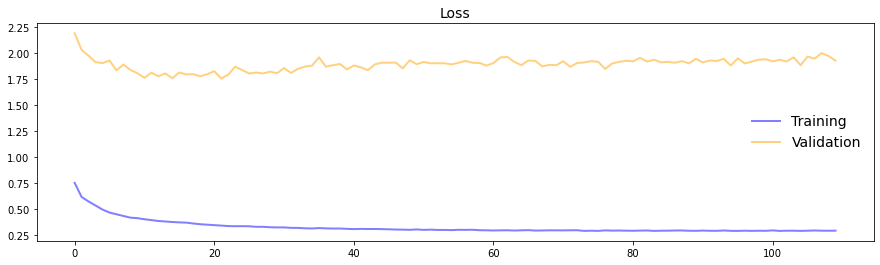

In [25]:
plt.figure( figsize = (15, 4) );

plt.plot( Loss['Train'], color='blue',   alpha = 0.5, linewidth = 2);
plt.plot( Loss['Valid'], color='orange', alpha = 0.5, linewidth = 2);
#
plt.legend(['Training', 'Validation'], frameon = False, fontsize = 14);
plt.title('Loss', size = 14);

## Load optimized model

In [26]:
# Load best model
#
model.load_state_dict( torch.load( args.model_path ) );
model.eval();

print('[INFO] Model loaded')

[INFO] Model loaded


## Evaluation

### Get predictions

In [27]:
pred = None
with torch.no_grad():
    for data, target, XTime, YTime in tqdm( test_dl ):

        data   = torch.tensor(data,   dtype=torch.float32)
        target = torch.tensor(target, dtype=torch.float32)

        if (pred is None):
            pred = model( data, XTime, YTime ).squeeze(-1).cpu().detach().numpy()
        else:
            pred = np.concatenate([ pred, model( data, XTime, YTime ).squeeze(-1).cpu().detach().numpy() ])

100%|██████████| 1/1 [00:00<00:00, 99.96it/s]


### Apply inverse scaling/transformation

In [28]:
# Apply inverse scaling
#
for i in range( args.Horizon ):
    testY[:,  i] = scaler.inverse_transform( testY[:,  i].reshape(-1,1) ).squeeze(-1)
    pred[:, i]   = scaler.inverse_transform( pred[:, i].reshape(-1,1) ).squeeze(-1)


# Apply inverse transformation   
#
if (args.Transformation == True):
    testY = np.exp( testY ) - VALUE
    pred  = np.exp( pred )  - VALUE

### Calculate Performance on Testing set - Prediction visualization


In [29]:
print('[INFO] Feature: ', args.targetSeries)
print('------------------------------------------------')
Prices = pd.DataFrame([])        

Prices[ args.targetSeries ] = testY.flatten()
Prices[ 'Prediction'      ] = pred.flatten()

# Evaluation
#
MAE, RMSE, MAPE, SMAPE, R2 = RegressionEvaluation( Prices )

print('    - \t    MAE %5.2f RMSE %5.2f SMAPE: %5.2f R2: %.2f\n' % (MAE, RMSE, SMAPE, R2) )

Performance_Foresting_Model = {'RMSE': [], 'MAE': [], 'SMAPE': [], 'R2' : []}

for i in range( args.Horizon ):

    Prices = pd.DataFrame([])        

    Prices[ args.targetSeries ] = testY[:,i]
    Prices[ 'Prediction'      ] = pred[:,i]


    # Evaluation
    #
    MAE, RMSE, MAPE, SMAPE, R2 = RegressionEvaluation( Prices )

    # Store results
    #
    Performance_Foresting_Model['RMSE']    += [ RMSE    ]
    Performance_Foresting_Model['MAE']     += [ MAE     ]
    Performance_Foresting_Model['SMAPE']   += [ SMAPE   ]
    Performance_Foresting_Model['R2']      += [ R2      ]

    # Present results
    #
    print('Horizon: %2i MAE %5.2f RMSE %5.2f SMAPE: %5.2f R2: %.2f' % (i+1, MAE, RMSE, SMAPE, R2) )

[INFO] Feature:  W_elect
------------------------------------------------
    - 	    MAE  1.38 RMSE  1.97 SMAPE: 57.15 R2: 0.13

Horizon:  1 MAE  1.46 RMSE  2.03 SMAPE: 94.59 R2: 0.67
Horizon:  2 MAE  1.62 RMSE  2.14 SMAPE: 89.90 R2: 0.55
Horizon:  3 MAE  1.59 RMSE  2.06 SMAPE: 77.37 R2: 0.35
Horizon:  4 MAE  1.54 RMSE  1.96 SMAPE: 61.54 R2: -0.06
Horizon:  5 MAE  1.61 RMSE  2.08 SMAPE: 57.60 R2: -0.36
Horizon:  6 MAE  1.67 RMSE  2.16 SMAPE: 59.16 R2: -0.35
Horizon:  7 MAE  1.29 RMSE  1.84 SMAPE: 44.53 R2: -0.47
Horizon:  8 MAE  0.85 RMSE  1.20 SMAPE: 33.13 R2: -1.13
Horizon:  9 MAE  0.78 RMSE  1.11 SMAPE: 31.82 R2: -0.95
Horizon: 10 MAE  0.78 RMSE  1.11 SMAPE: 31.52 R2: -0.82
Horizon: 11 MAE  0.77 RMSE  1.11 SMAPE: 30.52 R2: -0.81
Horizon: 12 MAE  0.71 RMSE  0.95 SMAPE: 29.09 R2: -1.40
Horizon: 13 MAE  0.70 RMSE  0.94 SMAPE: 31.10 R2: -1.67
Horizon: 14 MAE  0.71 RMSE  1.01 SMAPE: 30.34 R2: -0.98
Horizon: 15 MAE  0.72 RMSE  1.01 SMAPE: 30.00 R2: -2.00
Horizon: 16 MAE  0.70 RMSE  0.99 S

In [30]:

# [INFO] Feature:  W_elect
# ------------------------------------------------
#     - 	    MAE  1.38 RMSE  1.97 SMAPE: 57.15 R2: 0.13

# Horizon:  1 MAE  1.46 RMSE  2.03 SMAPE: 94.59 R2: 0.67
# Horizon:  2 MAE  1.62 RMSE  2.14 SMAPE: 89.90 R2: 0.55
# Horizon:  3 MAE  1.59 RMSE  2.06 SMAPE: 77.37 R2: 0.35
# Horizon:  4 MAE  1.54 RMSE  1.96 SMAPE: 61.54 R2: -0.06
# Horizon:  5 MAE  1.61 RMSE  2.08 SMAPE: 57.60 R2: -0.36
# Horizon:  6 MAE  1.67 RMSE  2.16 SMAPE: 59.16 R2: -0.35
# Horizon:  7 MAE  1.29 RMSE  1.84 SMAPE: 44.53 R2: -0.47
# Horizon:  8 MAE  0.85 RMSE  1.20 SMAPE: 33.13 R2: -1.13
# Horizon:  9 MAE  0.78 RMSE  1.11 SMAPE: 31.82 R2: -0.95
# Horizon: 10 MAE  0.78 RMSE  1.11 SMAPE: 31.52 R2: -0.82
# Horizon: 11 MAE  0.77 RMSE  1.11 SMAPE: 30.52 R2: -0.81
# Horizon: 12 MAE  0.71 RMSE  0.95 SMAPE: 29.09 R2: -1.40
# Horizon: 13 MAE  0.70 RMSE  0.94 SMAPE: 31.10 R2: -1.67
# Horizon: 14 MAE  0.71 RMSE  1.01 SMAPE: 30.34 R2: -0.98
# Horizon: 15 MAE  0.72 RMSE  1.01 SMAPE: 30.00 R2: -2.00
# Horizon: 16 MAE  0.70 RMSE  0.99 SMAPE: 28.45 R2: -1.54
# Horizon: 17 MAE  0.89 RMSE  1.16 SMAPE: 35.60 R2: -1.42
# Horizon: 18 MAE  1.76 RMSE  2.40 SMAPE: 54.23 R2: -0.34
# Horizon: 19 MAE  2.13 RMSE  2.76 SMAPE: 64.15 R2: -0.27
# Horizon: 20 MAE  1.90 RMSE  2.40 SMAPE: 64.81 R2: -0.44
# Horizon: 21 MAE  1.85 RMSE  2.38 SMAPE: 72.54 R2: -0.04
# Horizon: 22 MAE  2.18 RMSE  2.79 SMAPE: 90.88 R2: 0.18
# Horizon: 23 MAE  2.44 RMSE  3.16 SMAPE: 111.31 R2: 0.23
# Horizon: 24 MAE  2.47 RMSE  3.21 SMAPE: 117.45 R2: 0.26

## Examples

## Part 1

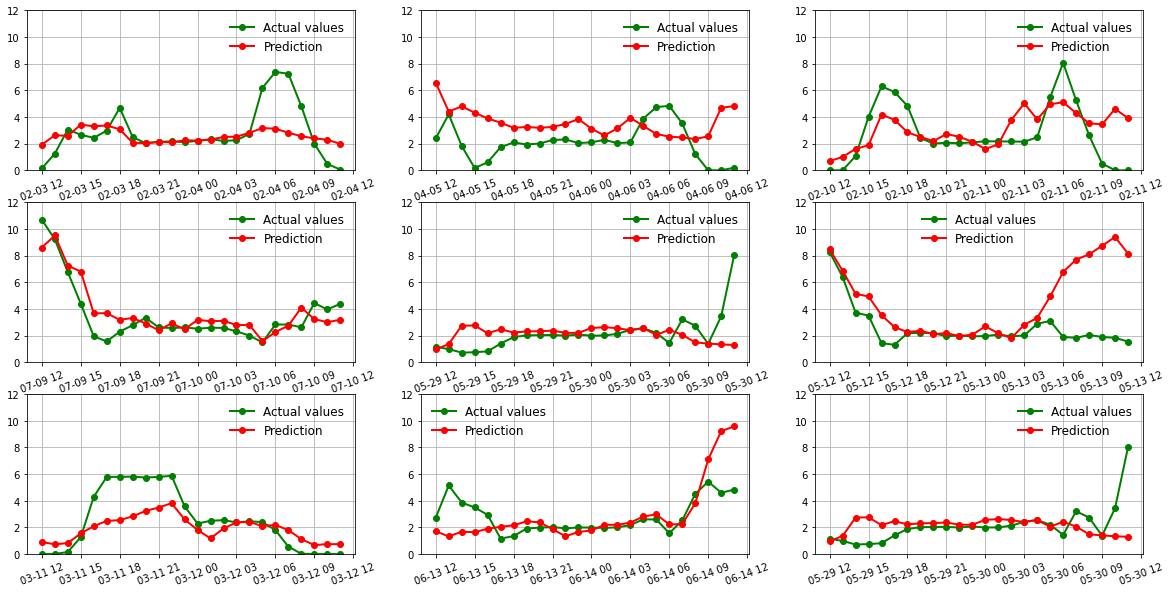

In [31]:
subplots = [331, 332, 333, 334, 335, 336,  337, 338, 339]
plt.figure( figsize = (20, 10) )

# Select random cases
RandomInstances = [random.randint(1, testY.shape[0]) for i in range(0, 9)]


for plot_id, i in enumerate(RandomInstances):

    plt.subplot(subplots[plot_id])
    plt.grid()
    plt.plot(testDate[i], testY[i], color = 'g', marker = 'o', linewidth = 2)
    plt.plot(testDate[i], pred[i],  color = 'r', marker = 'o', linewidth = 2)
    

    
    plt.legend(['Actual values', 'Prediction'], frameon = False, fontsize = 12)
    plt.ylim([0, 12])
    plt.xticks(rotation = 20)
plt.show()

## Part 2

In [32]:
# Apply inverse scaling on trainX
#
for i in range( trainX.shape[1] ):
    testX[:,  i, 0] = scaler.inverse_transform( testX[:, i, 0].reshape(-1,1) ).squeeze(-1)


# Apply inverse transformation   
#
if (args.Transformation == True):
    testX = np.exp( testX ) - VALUE

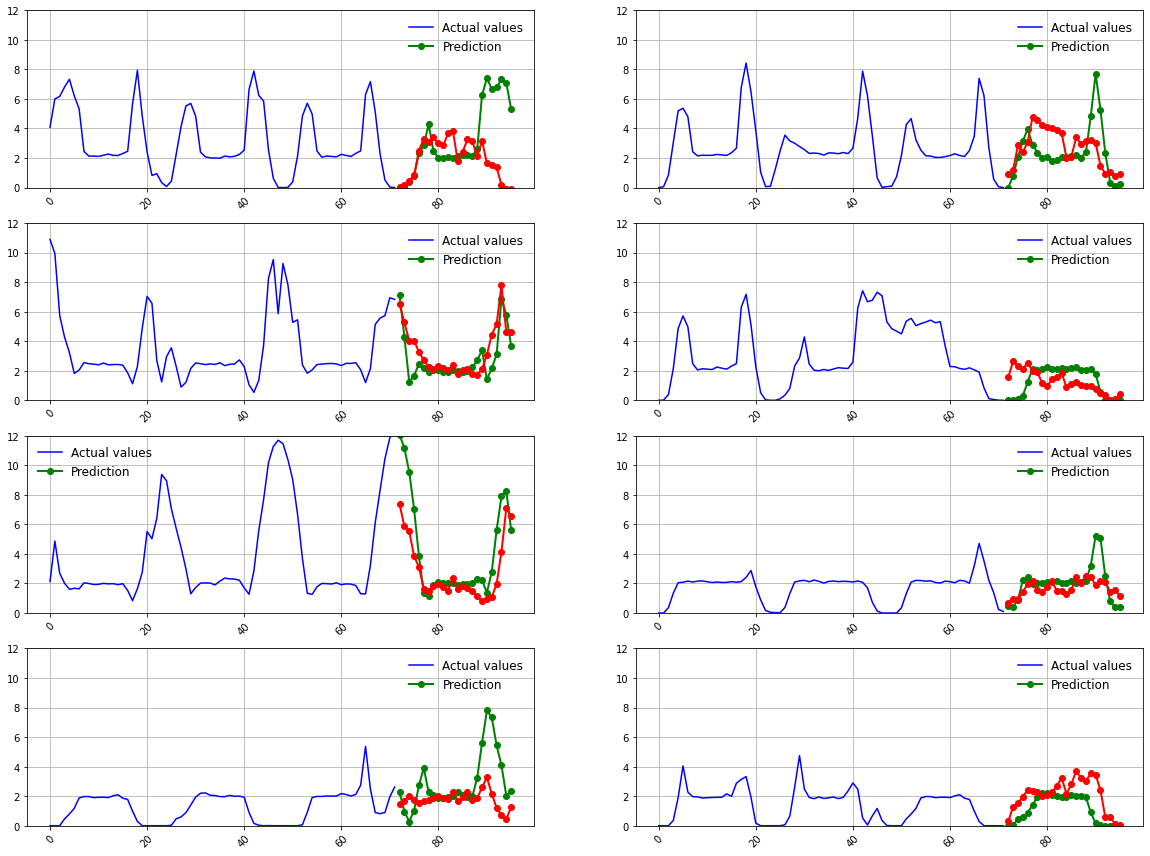

In [33]:
subplots = [421, 422, 423, 424, 425, 426, 427, 428]
plt.figure( figsize = (20, 15) )

# Select random cases
RandomInstances = [random.randint(1, testY.shape[0]) for i in range(0, 8)]


for plot_id, i in enumerate(RandomInstances):

    plt.subplot(subplots[plot_id])
    plt.grid()
#     plt.plot(testDate[i], testY[i], color='g', marker = 'o', linewidth = 2)
#     plt.plot(testDate[i], pred[i],  color='r', marker = 'o', linewidth = 2)
    
    plt.plot(range(0, 3*24),    testX[i,:,0], color = 'b')
    plt.plot(range(3*24, 4*24), testY[i],     color = 'g', marker = 'o', linewidth = 2)
    plt.plot(range(3*24, 4*24), pred[i],      color = 'r', marker = 'o', linewidth = 2)


    
    plt.legend(['Actual values', 'Prediction'], frameon = False, fontsize = 12)
    plt.ylim([0, 12])
    plt.xticks(rotation=45)
plt.show()